# Audio Emotion Classifier
Goal: Classify emotions (happy, angry, sad, etc.) from short speech audio clips.  
Dataset: [CREMA-D](https://gitlab.com/cs-cooper-lab/crema-d-mirror/)  


## Environment

In [48]:
import os

import matplotlib.pyplot as plt

import librosa

from IPython.display import Audio

import torch
from torch.utils.data import Dataset, DataLoader

import torchaudio
from torchaudio import transforms

from sklearn.model_selection import train_test_split

import collections

## Data
First clone dataset and copy AudioWAV to data/AudioWAV

In [22]:
ROOT_DIR = "data/AudioWAV"
sample_names = os.listdir(ROOT_DIR)

## Explore data

In [23]:
print(sample_names[0])

1040_ITH_SAD_XX.wav


In [24]:
sample_example = os.path.join(ROOT_DIR, sample_names[0])
print(torchaudio.info(sample_example))

AudioMetaData(sample_rate=16000, num_frames=43777, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [25]:
waveform, sample_rate = torchaudio.load(sample_example)
print(f"Shape of the waveform: {waveform.size()}\n")
print(f"Sampling rate of the audio file: {sample_rate}")

Shape of the waveform: torch.Size([1, 43777])

Sampling rate of the audio file: 16000


In [26]:
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)

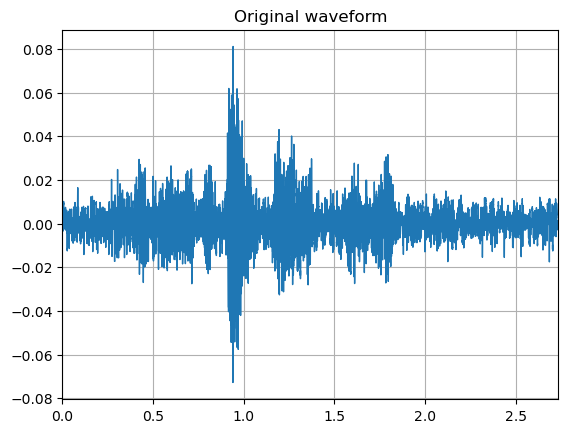

In [27]:
plot_waveform(waveform, sample_rate, title="Original waveform")

In [28]:
Audio(waveform.numpy(), rate=sample_rate)

## Transform

### Resample

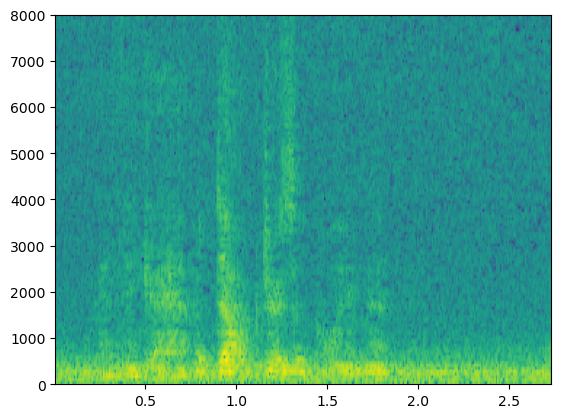

In [29]:
RESAMPLE_RATE = 16_000

resampler = transforms.Resample(sample_rate, RESAMPLE_RATE, dtype=waveform.dtype)
resampled_waveform = resampler(waveform)

resampled_specgram = plt.specgram(resampled_waveform[0].numpy(), Fs=RESAMPLE_RATE)

In [30]:
Audio(resampled_waveform.numpy(), rate=RESAMPLE_RATE)

### Trim or Pad to ensure fixed length

In [31]:
def enforce_3_seconds(waveform: torch.Tensor, sample_rate: int) -> torch.Tensor:
    desired_length_seconds = 3
    desired_samples = int(desired_length_seconds * sample_rate)

    current_samples = waveform.shape[-1] # waveform.shape will be (channels, samples)

    if current_samples == desired_samples:
        return waveform
    elif current_samples > desired_samples:
        trimmed_waveform = waveform[..., :desired_samples]
        return trimmed_waveform
    else:
        padding_needed = desired_samples - current_samples
        # Create a tensor of zeros for padding, maintaining the number of channels
        padding = torch.zeros(waveform.shape[0], padding_needed, dtype=waveform.dtype)
        padded_waveform = torch.cat((waveform, padding), dim=-1)
        return padded_waveform

In [32]:
fixed_waveform = enforce_3_seconds(resampled_waveform, RESAMPLE_RATE)

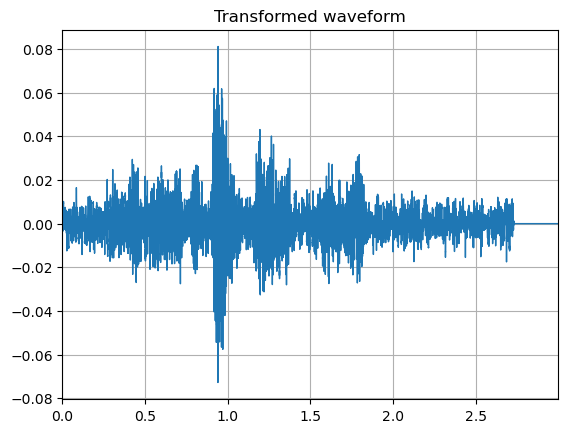

In [33]:
plot_waveform(fixed_waveform, RESAMPLE_RATE, title="Transformed waveform")

In [34]:
Audio(fixed_waveform.numpy(), rate=RESAMPLE_RATE)

### Mel Spectogram

In [35]:
mel_transform = transforms.MelSpectrogram(RESAMPLE_RATE)
mel_spectogram = mel_transform(fixed_waveform)
db_transform = transforms.AmplitudeToDB(stype="power") # Use "power" since MelSpectrogram default power=2
mel_specgram_db = db_transform(mel_spectogram)

/home/martin/miniconda/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


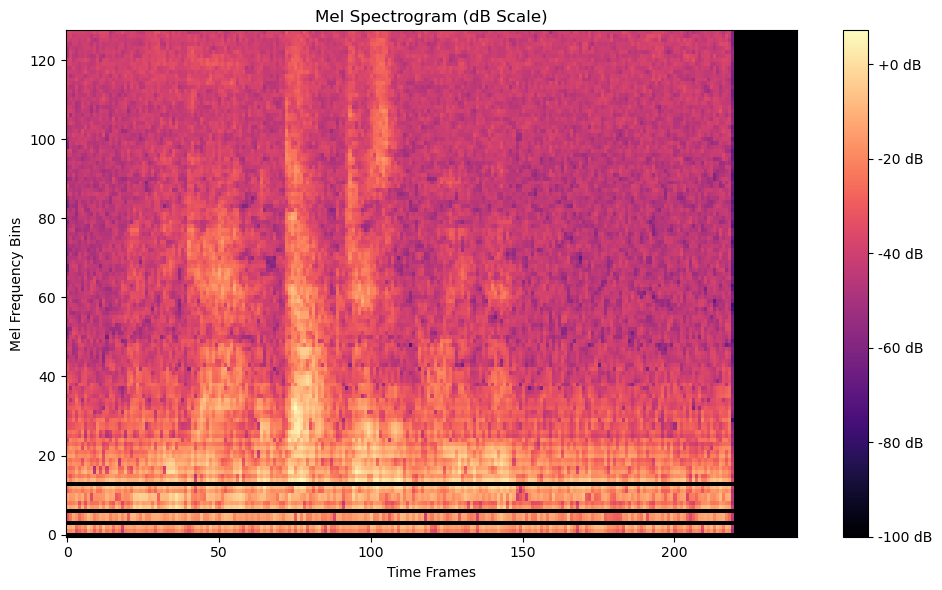

In [36]:
plt.figure(figsize=(10, 6))

# Plot the Mel spectrogram in decibels
# Convert the tensor to a NumPy array and remove the channel dimension
# Use .squeeze() if you have a single channel, or select the channel if multiple
plt.imshow(
    mel_specgram_db.squeeze().numpy(),
    origin="lower",
    aspect="auto",
    cmap="magma",
    interpolation="nearest",
)

plt.title("Mel Spectrogram (dB Scale)")
plt.xlabel("Time Frames")
plt.ylabel("Mel Frequency Bins")
plt.colorbar(format="%+2.0f dB")
plt.tight_layout() # Adjusts plot to prevent labels from overlapping
plt.show()

### Transform Pipeline

In [52]:
def transform_sample(sample_path):
    waveform, sample_rate = torchaudio.load(sample_path)

    resampler = transforms.Resample(sample_rate, RESAMPLE_RATE, dtype=waveform.dtype)
    resampled_waveform = resampler(waveform)

    fixed_waveform = enforce_3_seconds(resampled_waveform, RESAMPLE_RATE)

    mel_transform = transforms.MelSpectrogram(RESAMPLE_RATE)
    return mel_transform(fixed_waveform)

### Stratified Train/Test Split

In [43]:
classes = ["ANG", "DIS", "FEA", "HAP", "NEU", "SAD"]

def extract_emotion(sample_name):
    label = None
    for i, cls in enumerate(classes):
        if cls in sample_name:
            label = i
            break 

    if label is None:
        print(sample_name)

    return label

labels = [extract_emotion(sample_name) for sample_name in sample_names]

train_sample_names, test_sample_names, train_labels, test_labels = train_test_split(
    sample_names, labels, test_size=0.1, random_state=42, stratify=labels
)

print(f"Train samples: {len(train_sample_names)}")
print(f"Test samples: {len(test_sample_names)}")

Train samples: 6697
Test samples: 745


In [46]:
train_sample_names[0]

'1003_ITS_NEU_XX.wav'

In [47]:
test_sample_names[0]

'1005_IEO_FEA_LO.wav'

In [44]:
train_labels[0]

4

In [45]:
test_labels[0]

2

In [49]:
def count_labels(labels):
    label_counts = collections.Counter()

    for label in labels:
        label_counts[label] += 1

    total_count = sum(label_counts.values())
    label_ratios = {label: count / total_count for label, count in label_counts.items()}
    
    sorted_label_ratios = dict(sorted(label_ratios.items()))

    return sorted_label_ratios

print(count_labels(train_labels))
print(count_labels(test_labels))

{0: 0.17082275645811557, 1: 0.17082275645811557, 2: 0.17082275645811557, 3: 0.17067343586680603, 4: 0.14603553830073168, 5: 0.17082275645811557}
{0: 0.1704697986577181, 1: 0.1704697986577181, 2: 0.1704697986577181, 3: 0.17181208053691274, 4: 0.14630872483221477, 5: 0.1704697986577181}


### Datasets

In [50]:
class EmotionalAudioDataset(Dataset):
    def __init__(self, sample_names, labels, transform):
        self.sample_names = sample_names
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.sample_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample_name = self.sample_names[idx]
        sample_path = os.path.join(ROOT_DIR, sample_name)
        sample = self.transform(sample_path)

        label = self.labels[idx]

        return {"sample": sample, "label": label}

In [53]:
train_dataset = EmotionalAudioDataset(train_sample_names, train_labels, transform_sample)
test_dataset = EmotionalAudioDataset(test_sample_names, test_labels, transform_sample)

In [54]:
next(iter(train_dataset))

/home/martin/miniconda/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


{'sample': tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.6309e-03, 2.0044e-03, 2.5657e-04,  ..., 5.3444e-04,
           1.9252e-03, 2.0683e-02],
          [3.0318e-02, 1.0792e-02, 1.3814e-03,  ..., 2.8776e-03,
           1.0366e-02, 1.1136e-01],
          ...,
          [1.1516e-04, 1.3511e-04, 3.0210e-05,  ..., 1.7434e-04,
           7.0057e-04, 1.5748e-03],
          [2.9038e-05, 9.3166e-05, 3.3958e-05,  ..., 5.7971e-04,
           5.4122e-04, 9.5517e-04],
          [2.7406e-05, 4.0061e-05, 3.8809e-05,  ..., 3.8300e-04,
           2.4798e-04, 6.8862e-04]]]),
 'label': 4}